# Wavelet CNN

## Imports

In [37]:
import os
import optuna
import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from pytorch_wavelets import DWTForward
from tqdm import tqdm
import random
from torchviz import make_dot

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

In [38]:
# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())


DEVICE = 0

Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 76115968
Cached GPU memory: 130023424


## Settings

In [39]:
DATASET = 'SalA'    

if DATASET == 'Sal':
    N_PCA = 170
    TRAIN_SIZE = 0.2990 
    EPOCH = 82    
    BATCH_SIZE = 32
    PATCH_SIZE = 13 
    LR = 0.000269    
    WEIGHT_DECAY = 0.0001616  

elif DATASET == 'SalA':
    N_PCA = 150
    TRAIN_SIZE = 0.2721    
    EPOCH = 55    
    BATCH_SIZE = 32
    PATCH_SIZE = 31 
    LR = 0.006597    
    WEIGHT_DECAY = 1e-6 

elif DATASET == 'Indian Pines':
    N_PCA = 190
    TRAIN_SIZE = 0.2755    
    EPOCH = 30    
    BATCH_SIZE = 32
    PATCH_SIZE = 19 
    LR = 0.00726738    
    WEIGHT_DECAY = 0.000640487  
    
elif DATASET == 'PaviaU':
    N_PCA = 103
    TRAIN_SIZE = 0.2892    
    EPOCH = 77    
    BATCH_SIZE = 64
    PATCH_SIZE = 9 
    LR = 0.0005042    
    WEIGHT_DECAY = 0.0001894

else:
    N_PCA = 190
    
ALL_BANDS = False
VAL_EPOCH = 5
VAL_RATE = 0.1    
RANDOM_SEED=42

print(f'Number of bands utilized: {N_PCA}') 
print(f'Training size: {TRAIN_SIZE}') 
print(f'Epochs: {EPOCH}') 
print(f'Batch size: {BATCH_SIZE}') 
print(f'Patch size: {PATCH_SIZE}') 
print(f'Learning rate: {LR}') 
print(f'Weight decay: {WEIGHT_DECAY}') 

Number of bands utilized: 150
Training size: 0.2721
Epochs: 55
Batch size: 32
Patch size: 31
Learning rate: 0.006597
Weight decay: 1e-06


In [40]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



SAVE_PATH = f"results\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)

## Dataset

In [41]:

def load_dataset(dataset_name):
    datapath = os.path.join(os.getcwd(),'Datasets')
    if dataset_name == 'Indian Pines':
        data = sio.loadmat(os.path.join(datapath, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(datapath, 'Indian_pines_gt.mat'))['indian_pines_gt']
        class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", 
                       "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats","Soybean-notill",
                         "Soybean-mintill", "Soybean-clean","Wheat", "Woods",
                           "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
        
    elif dataset_name == 'SalA':
        data = sio.loadmat(os.path.join(datapath, 'SalinasA_corrected.mat'))['salinasA_corrected']
        labels = sio.loadmat(os.path.join(datapath, 'SalinasA_gt.mat'))['salinasA_gt']
        class_name = [ "Brocoli_green_weeds_1", "Corn_senesced_green_weeds", "Lettuce_romaine_4wk",
                       "Lettuce_romaine_5wk", "Lettuce_romaine_6wk", "Lettuce_romaine_7wk" ]
        

    elif dataset_name == 'Sal':
        data = sio.loadmat(os.path.join(datapath, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(datapath, 'Salinas_gt.mat'))['salinas_gt']
        class_name = [ "Brocoli_green_weeds_1", "Brocoli_green_weeds_2", "Fallow", "Fallow_rough_plow", "Fallow_smooth", "Stubble", "Celery", "Grapes_untrained",
                      "Soil_vinyard_develop",  "Corn_senesced_green_weeds", "Lettuce_romaine_4wk",
                       "Lettuce_romaine_5wk", "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained", "Vinyard_vertical_trellis" ]
        

    elif dataset_name == 'PaviaU':
        data = sio.loadmat(os.path.join(datapath, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(datapath, 'PaviaU_gt.mat'))['paviaU_gt']
        class_name = [ "Asphalt", "Meadows", "Gravel", "Trees",
                       "Painted metal sheets", "Bare Soil",
                         "Bitumen", "Self-Blocking Bricks", "Shadows" ]
    else:
        raise ValueError(f"Dataset {dataset_name} not supported.")
    return data, labels, class_name

data, labels, class_name = load_dataset(DATASET)
NUM_CLASS = labels.max()
print('Image shape:' + str(data.shape))
print(f"Label shape: {labels.shape}")
print(f"Number of classes: {NUM_CLASS}")

Image shape:(83, 86, 204)
Label shape: (83, 86)
Number of classes: 14


## Pre-process data

### Dimensionality Reduction (PCA)

In [42]:
def applyPCA(X, numComponents):
    """PCA processing

    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional): number of reserved components. Defaults to 15.

    Returns:
        newX: _description_
    """
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)   ##PCA and normalization
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca



### Create image patches (zero-padding)

In [43]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 

        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label

In [44]:

def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt


## Print 

### Display HSI

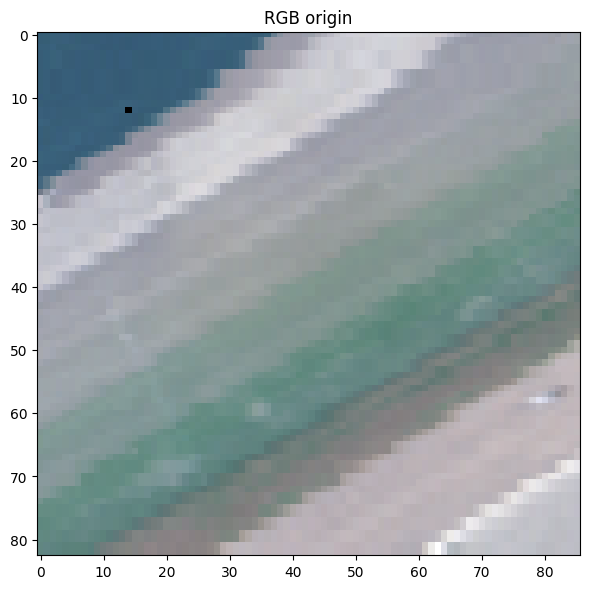

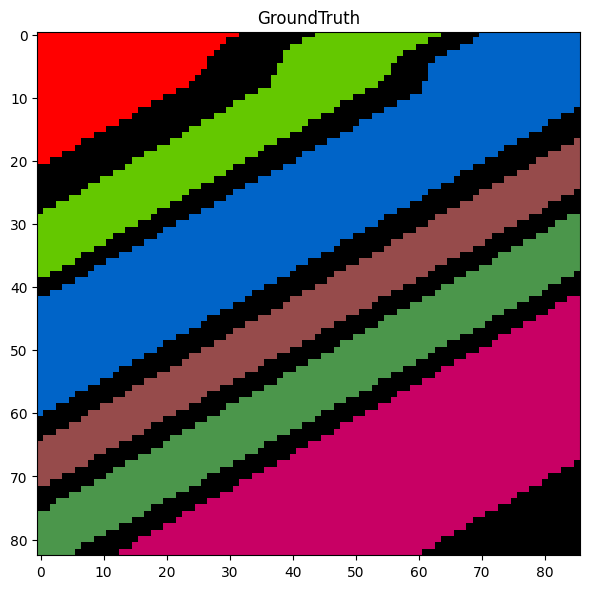

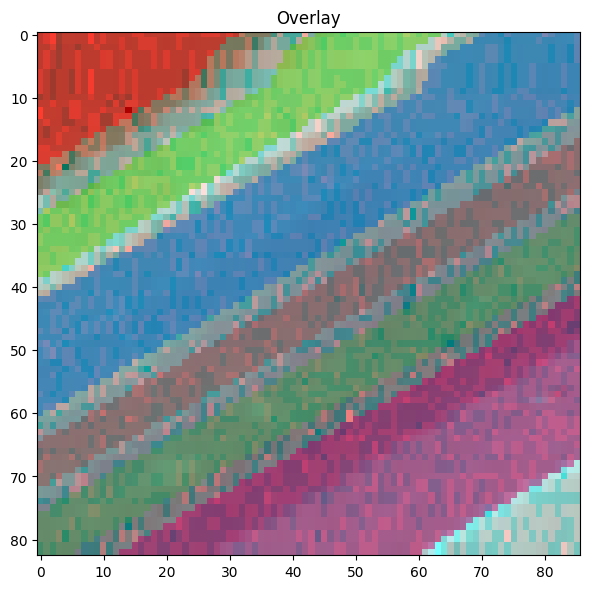

In [45]:
rgb_view = spectral.imshow(data, (29, 20, 10), classes=labels, title='RGB origin', figsize=(7, 7))
gt_view = spectral.imshow(classes=labels, title='GroundTruth', figsize=(7, 7))
view = spectral.imshow(data, (0, 10, 20), classes=labels, figsize=(7, 7))
view.set_display_mode('overlay')
view.class_alpha = 0.5
view.set_title('Overlay')

## Data Split

In [46]:
data,pca = applyPCA(data,N_PCA)
print('Image shape:' + str(data.shape))


Image shape:(83, 86, 150)


In [47]:

train_gt, test_gt = sample_gt(labels, TRAIN_SIZE)


  class   train_num  test_num   total   
    1        106       285       391    
    10       366       977       1343   
    11       168       448       616    
    12       415       1110      1525   
    13       183       491       674    
    14       217       582       799    
  total      1455      3893      5348   


c:\Users\Philip Shahdadfar\AppData\Local\Programs\Python\Python312\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Interpolation       :  <default>

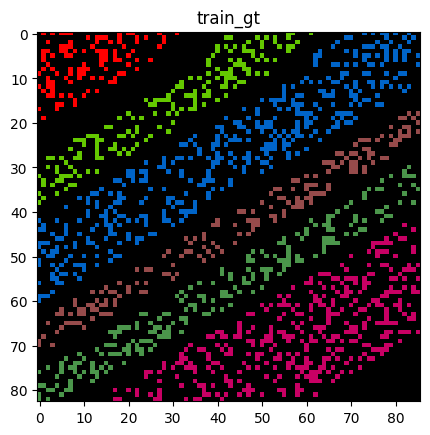

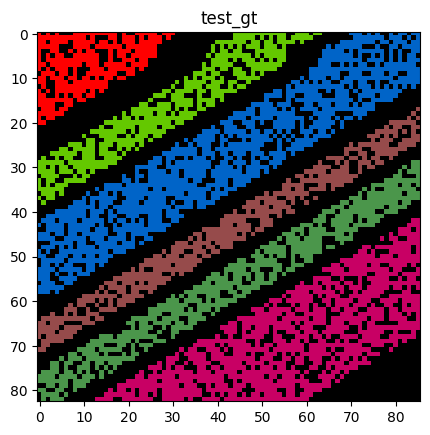

In [48]:

## Samples info
sample_report = f"{'class': ^10}{'train_num':^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(labels):
    if i == 0: continue
    sample_report += f"{i: ^10}{(train_gt == i).sum(): ^10}{(test_gt == i).sum(): ^10}{(labels == i).sum(): ^10}\n"
sample_report += f"{'total': ^10}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(labels): ^10}"
print(sample_report)
spectral.imshow(classes=train_gt, title='train_gt')
spectral.imshow(classes=test_gt, title='test_gt')


### Create dataset and dataloader

In [49]:

train_data = PatchSet(data, train_gt, PATCH_SIZE)
test_data = PatchSet(data, test_gt, PATCH_SIZE)
all_data = PatchSet(data, labels, PATCH_SIZE, is_pred=True)
train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=True)
all_loader = DataLoader(all_data, BATCH_SIZE, shuffle=False)


In [50]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([150, 31, 31]), tensor(11))

## Model

In [51]:
class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=2, base_channels=16):
        super(WaveletCNN, self).__init__()
        self.levels = levels
        self.base_channels = base_channels

        # Wavelet transform
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])
        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()

        for i in range(levels):
            prev_channels = sum(base_channels * (2 ** j) for j in range(i))
            input_channels = in_channels + 3 * in_channels + prev_channels
            output_channels = base_channels * (2 ** i)
            
            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            ))

        total_channels = sum(base_channels * (2 ** i) for i in range(levels))

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(total_channels, class_nums)

    def forward(self, x):
        features = []
        low_pass = x

        for i in range(self.levels):
          
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape

           
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)

        
            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]

            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
      
            
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
           
            
            features.append(conv_out)

       
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]

        out = torch.cat(resized_features, dim=1)
        out = self.global_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


In [52]:
# Initialize the model
net = WaveletCNN(in_channels=N_PCA, class_nums=NUM_CLASS)

# Input tensor
input_tensor = torch.randn(1, N_PCA, PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, N_PCA, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)

Input tensor shape: torch.Size([1, 150, 31, 31])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 150, 31, 31]   [1, 14]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 150, 31, 31]   [1, 150, 16, 16]
├─ModuleList (projections)               (recursive)        --                 --                 --                 --
│    └─Conv2d (0)                        9,616              [1, 1]             2,461,696          [1, 600, 16, 16]   [1, 16, 16, 16]
├─ModuleList (conv_blocks)               (recursive)        --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 16, 16, 16]    [

## Training

In [53]:

## training the model
device = torch.device(DEVICE if DEVICE >= 0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []

model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()



start_training_time = time.time()

try:
    # Epoch-level progress bar
    epoch_progress = tqdm(range(EPOCH), desc="Training Progress", unit="epoch")

    for e in epoch_progress:
        epoch_start_time = time.time()
        model.train()
        avg_loss = 0.
        train_acc = 0

        # Batch-level progress bar (nested within epoch)
        batch_progress = tqdm(enumerate(train_loader), total=batch_num, desc=f"Epoch {e+1}/{EPOCH}", leave=False, unit="batch")

        for batch_idx, (data, target) in batch_progress:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out, target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _, pred = torch.max(out, dim=1)
            train_acc += (pred == target).sum().item()

            # **Update batch progress bar dynamically**
            batch_progress.set_postfix(loss=loss.item(), acc=(train_acc / ((batch_idx + 1) * data.size(0))))

        loss_list.append(avg_loss / train_num)
        acc_list.append(train_acc / train_num)

        # **Update the epoch progress bar instead of printing**
        epoch_progress.set_description(f"Epoch {e+1}/{EPOCH} | Loss: {loss_list[-1]:.4f}, Acc: {acc_list[-1]:.4f}")

    # Save the final model after all epochs
    final_model_path = os.path.join(SAVE_PATH, 'final_model.pth')
    torch.save(model.state_dict(), final_model_path)
    print(f"Model saved to {final_model_path}")

except Exception as exc:
    print(exc)

finally: 
    total_training_time = time.time() - start_training_time
    print(f"Training completed in {total_training_time:.2f} seconds.")

Epoch 7/55 | Loss: 0.0010, Acc: 0.9931:  13%|█▎        | 7/55 [00:04<00:32,  1.47epoch/s]

Training completed in 4.77 seconds.


KeyboardInterrupt: 

### Save Best Model

In [ ]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    """get best model path by valuation list

    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir

    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

### Load

In [ ]:

# # ## inferring the whole image
final_model_path = os.path.join(SAVE_PATH, 'final_model.pth')
if not os.path.exists(final_model_path):
     raise FileNotFoundError(f"Final model file not found at {final_model_path}")

# # # Load the model
best_model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(final_model_path))
best_model.to(device)
best_model.eval()

# # # Perform inference
pred_map = []
for batch_idx, data in tqdm(enumerate(all_loader), total=len(all_loader)):
     data = data.to(device)
     target = best_model(data)
     _, pred = torch.max(target, dim=1)
     pred_map += [np.array(pred.detach().cpu() + 1)]  # class 0 in pred_map is class 1 in gt
pred_map = np.asarray(np.hstack(pred_map), dtype=np.uint8).reshape(labels.shape[0], labels.shape[1])

print(pred_map.shape)


C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_15080\2062524228.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(final_mode

(83, 86)


## Prediction

c:\Users\Philip Shahdadfar\AppData\Local\Programs\Python\Python312\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Interpolation       :  <default>

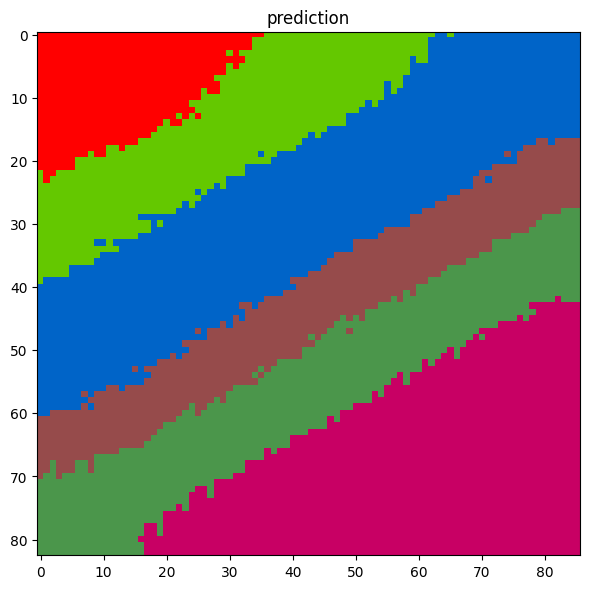

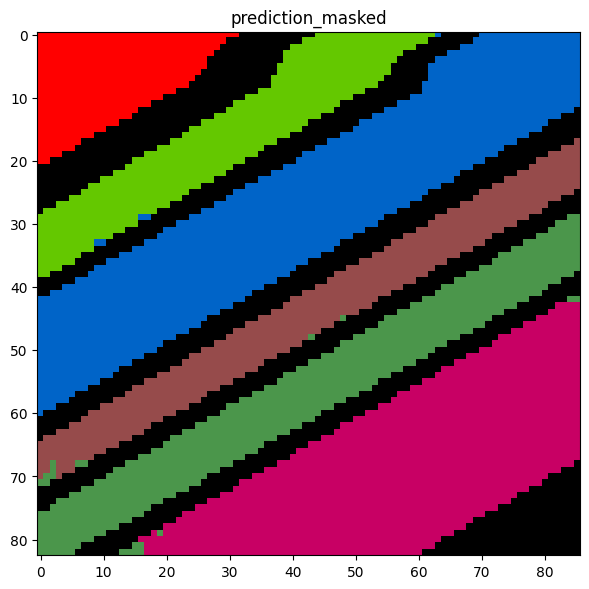

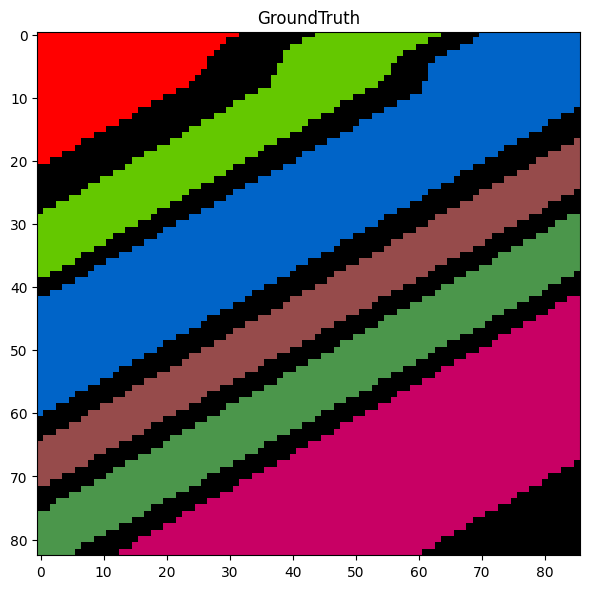

In [ ]:
spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
spectral.imshow(classes=pred_map*(labels!=0),title='prediction_masked',figsize=(7,7))
spectral.imshow(classes=labels, title='GroundTruth', figsize=(7, 7))
#spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction.jpg"),pred_map,colors = spectral.spy_colors)
#spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction_masked.jpg"),pred_map*(labels!=0),colors = spectral.spy_colors)
#spectral.save_rgb(os.path.join(SAVE_PATH,f"Groundtruth.jpg"),labels, colors=spectral.spy_colors)

## Evaluation

In [ ]:
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4, zero_division=0)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'classfication_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.9938350886206011
AA: 0.9932101356425703
Kappa: 0.9922824425154222
                           precision    recall  f1-score   support

    Brocoli_green_weeds_1     1.0000    1.0000    1.0000       285
Corn_senesced_green_weeds     1.0000    0.9908    0.9954       977
      Lettuce_romaine_4wk     1.0000    0.9888    0.9944       448
      Lettuce_romaine_5wk     0.9955    1.0000    0.9978      1110
      Lettuce_romaine_6wk     1.0000    0.9796    0.9897       491
      Lettuce_romaine_7wk     0.9684    1.0000    0.9839       582

                 accuracy                         0.9938      3893
                macro avg     0.9940    0.9932    0.9935      3893
             weighted avg     0.9940    0.9938    0.9939      3893



### Confusion Matrix

In [ ]:
unique_classes = np.unique(test_true)
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
test_true_remapped = np.array([class_mapping[val] for val in test_true])
test_pred_remapped = np.array([class_mapping[val] for val in test_pred])


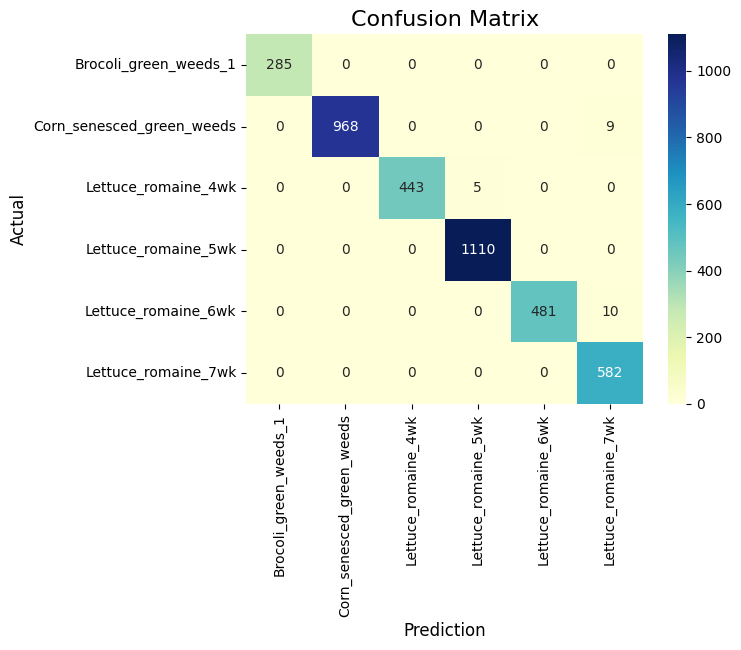

<Figure size 1000x1000 with 0 Axes>

Training completed in 33.71 seconds.
Completed in 40.03 seconds.


In [ ]:
cm = confusion_matrix(test_true_remapped, test_pred_remapped)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Prediction',fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.figure(figsize=(10, 10))
plt.show()
#plt.savefig(os.path.join(SAVE_PATH, 'confusion_matrix_with_values.png'))


total_time = time.time() - start_time
print(f"Training completed in {total_training_time:.2f} seconds.")
print(f"Completed in {total_time:.2f} seconds.")